In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl as ccl

In [3]:
cosmo = ccl.Cosmology(Omega_b=0.044, Omega_c=0.314, n_s=0.96, sigma8=0.8, h=0.67)

In [4]:
import healpy as hp
nside=512 # I put 512 for the sake of speed
max_ell = 3*nside
ells = np.arange(0, max_ell)

In [5]:
# We are going to simulate some galaxies with photo-z (sigmaz = 0.05*(1+z))
z = np.linspace(0, 1, 100)
zmean = 0.5
sigmaz = 0.05*(1+z)
dndz = np.exp(-0.5*(z-zmean)**2/sigmaz**2)

Text(0, 0.5, 'N(z)')

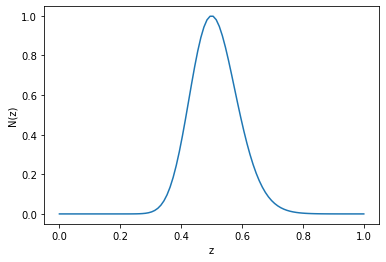

In [6]:
plt.plot(z, dndz)
plt.xlabel('z')
plt.ylabel('N(z)')

In [7]:
# We define some galaxies with the N(z) above and bias=1
tracer = ccl.NumberCountsTracer(cosmo, False, (z, dndz), (z, np.ones_like(z)))

In [8]:
#Let's get their power spectra
cls_in = ccl.angular_cl(cosmo, tracer, tracer, ells)

Text(0, 0.5, '$\\ell (\\ell+1) C_{\\ell}$')

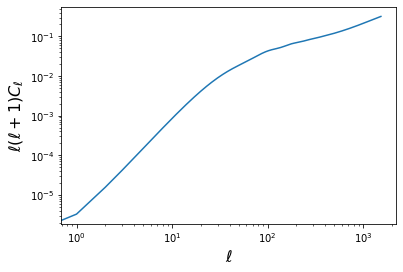

In [9]:
plt.loglog(ells, ells*(ells+1)*cls_in)
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$\ell (\ell+1) C_{\ell}$', fontsize=16)

In [10]:
lss_map = hp.synfast(cls_in, nside) # Generate a synthetic map with the power spectrum above

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


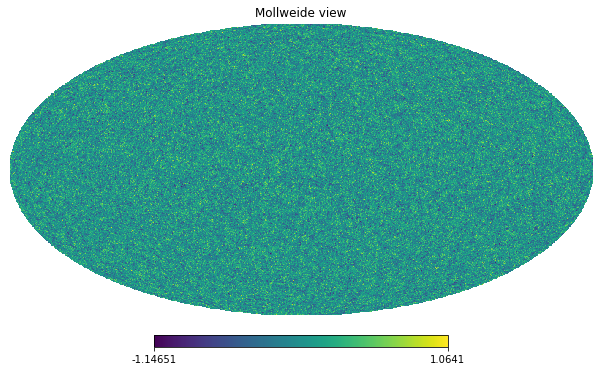

In [11]:
hp.mollview(lss_map) # This is the map of the matter density contrast with power spectrum as above, it will be enough for us

In [12]:
# Check that the power spectrum is indeed what we want
cls_out_test = hp.anafast(lss_map)

Text(0, 0.5, '$C_{\\ell}$')

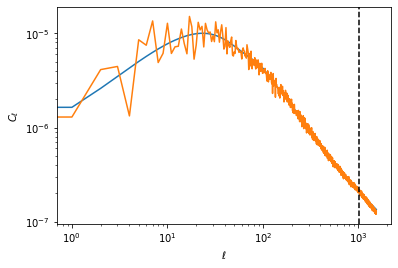

In [13]:
plt.loglog(ells, cls_in, label='Input')
plt.plot(ells, cls_out_test, label='Recovered')
plt.axvline(2*nside, ls='--', c='k') # for ell>2*Nside things may not be super accurate.
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [14]:
# Now we create contaminants and will add them to check their impact.
# I created 3 toy contaminants. We will try with more realistic ones later on.
cont1 = (ells+1.)**-0.7
cont2 = (ells+1.)**-2
cont3 = 0.1+(ells+1.)**0.2
temp1 = hp.synfast(cont1, nside)
temp2 = hp.synfast(cont2, nside)
temp3 = hp.synfast(cont3, nside)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


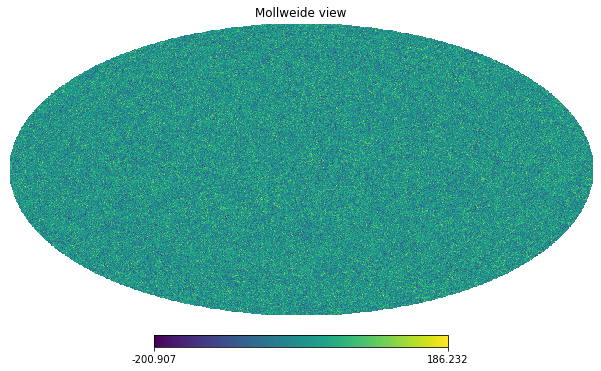

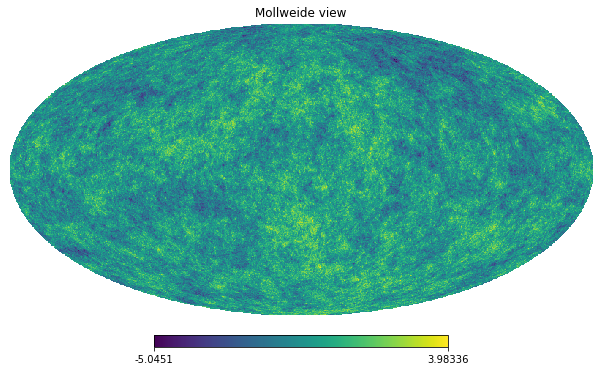

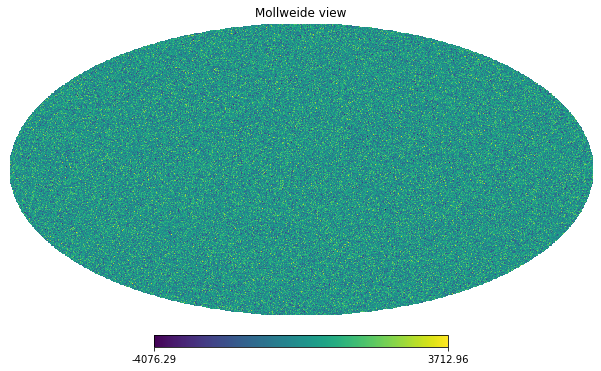

In [15]:
hp.mollview(temp1)
hp.mollview(temp2)
hp.mollview(temp3)

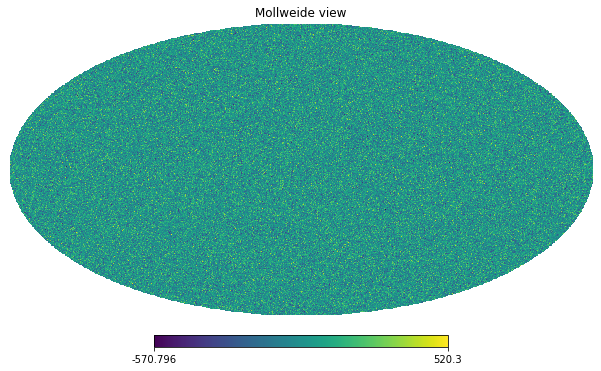

In [16]:
# Option 1: Check how deprojection works with additive contaminants
coupling1 = 0.05
coupling2 = 0.03
coupling3 = 0.14
measured_lss = lss_map+coupling1*temp1+coupling2*temp2+coupling3*temp3
hp.mollview(measured_lss)

In [17]:
import pymaster as nmt

In [18]:
bins = nmt.NmtBin(nside, nlb=1)

In [19]:
w = nmt.NmtWorkspace()

In [20]:
mask = np.ones_like(lss_map) # No mask, we see the whole sky here :p 
field = nmt.NmtField(mask, [measured_lss], templates=[[temp1], [temp2], [temp3]], n_iter=0)

In [28]:
import os

In [29]:
if os.path.isfile('nmt_wsp')==False:
    w.compute_coupling_matrix(field, field, bins, n_iter=0) # I believe that if you use a full-sky map you can skip this step
    # The workspace can be saved and the coupling matrix reused over and over if the mask is constant
    w.write_to('nmt_wsp.wsp')
else:
    w.read_from('nmt_wsp.wsp')

In [22]:
cl_th=w.decouple_cell(w.couple_cell([cls_in]))

In [23]:
# Compute the deprojection bias (no noise for now)
clb00=nmt.deprojection_bias(field,field,[cls_in]) # This step gets slower the larger the number of maps involved is

In [24]:
cls_meas=w.decouple_cell(nmt.compute_coupled_cell(field,field),cl_bias=clb00)

In [26]:
cls_naive = hp.anafast(measured_lss)

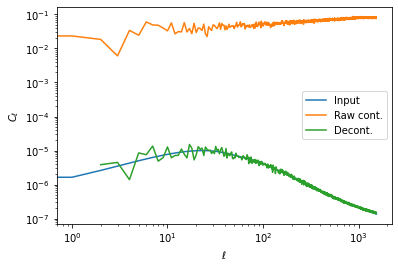

In [33]:
plt.loglog(ells, cls_in, label='Input')
plt.loglog(ells, cls_naive, label='Raw cont.')
plt.loglog(bins.get_effective_ells(), cls_meas[0], label='Decont.')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend(loc='best')

In [ ]:
# The idea is to repeat this with more contaminants and with a multiplicative contamination